In [11]:
import geopandas as gpd
import geoplot as gplt
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Salinity data for one month

In [24]:
# Load the NetCDF file
file_path = 'Salinity Data - Monthly Average\salinity_data\RSS_smap_SSS_L3_monthly_2021_01_FNL_v04.0.nc'
data_salinity = xr.open_dataset(file_path)

print(data_salinity.variables.keys())

KeysView(Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 1440)>
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 3.59375e+02, 3.59625e+02,
       3.59875e+02], dtype=float32)
Attributes:
    standard_name:  longitude
    axis:           X
    long_name:      center longitude of grid cell
    units:          degrees_east
    valid_min:      0.0
    valid_max:      360.0, 'lat': <xarray.IndexVariable 'lat' (lat: 720)>
array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
      dtype=float32)
Attributes:
    standard_name:  latitude
    axis:           Y
    long_name:      center latitude of grid cell
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0, 'time': <xarray.IndexVariable 'time' (time: 1)>
array(['2021-01-16T11:59:59.500000000'], dtype='datetime64[ns]')
Attributes:
    standard_name:  time
    axis:           T
    long_name:      reference time of analyzed variable field corresponding t..., 'nobs': <xarray.Variable (lat: 720, l

In [25]:
# Extract salinity, uncertainty, and relevant coordinates
sal = data_salinity['sss_smap']
sal_uncertainty = data_salinity['sss_smap_uncertainty']
sal_lon = data_salinity['lon']
sal_lat = data_salinity['lat']

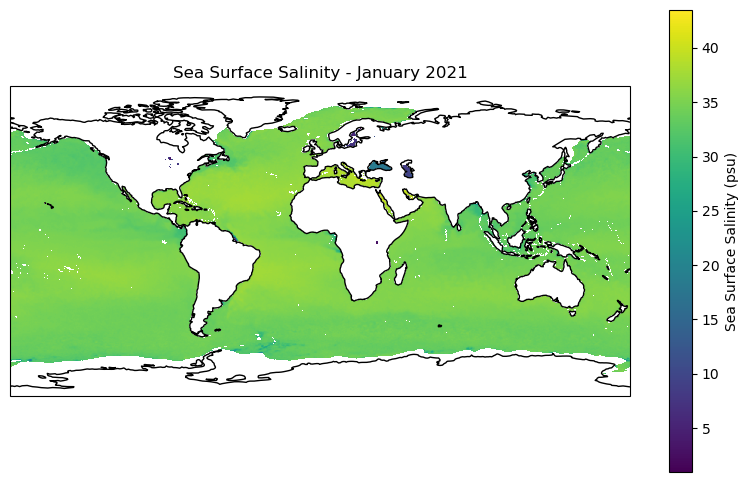

In [26]:
# Create a map projection (choose one appropriate for your region)
projection = ccrs.PlateCarree()  # Example: PlateCarree for global

# Create the figure and axes
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=projection)

# Plot the salinity data
salinity_plot = ax.pcolormesh(sal_lon, sal_lat, sal, cmap='viridis', transform=ccrs.PlateCarree())  # You can change the colormap

# Add coastlines and a colorbar
ax.coastlines()
plt.colorbar(salinity_plot, label='Sea Surface Salinity (psu)')

# Set title
plt.title('Sea Surface Salinity - January 2021')

# Show the plot
plt.show()


# Temperature data

In [27]:
# Load the NetCDF file
file_path = 'Temperature\sst.day.mean.2021.nc'
data_temperature = xr.open_dataset(file_path)

print(data_temperature.variables.keys())

KeysView(Frozen({'time': <xarray.IndexVariable 'time' (time: 365)>
array(['2021-01-01T00:00:00.000000000', '2021-01-02T00:00:00.000000000',
       '2021-01-03T00:00:00.000000000', ..., '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:     Time
    delta_t:       0000-00-01 00:00:00
    avg_period:    0000-00-01 00:00:00
    axis:          T
    actual_range:  [80719. 81083.], 'lat': <xarray.IndexVariable 'lat' (lat: 720)>
array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
      dtype=float32)
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    actual_range:   [-89.875  89.875]
    axis:           Y, 'lon': <xarray.IndexVariable 'lon' (lon: 1440)>
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 3.59375e+02, 3.59625e+02,
       3.59875e+02], dtype=float32)
Attributes:
    long_name:      Longitude
    

In [28]:
# Extract temperature and relevant coordinates
temp_time = data_temperature['time']
temp_lon = data_salinity['lon']
temp_lat = data_salinity['lat']
temp = data_temperature['sst']

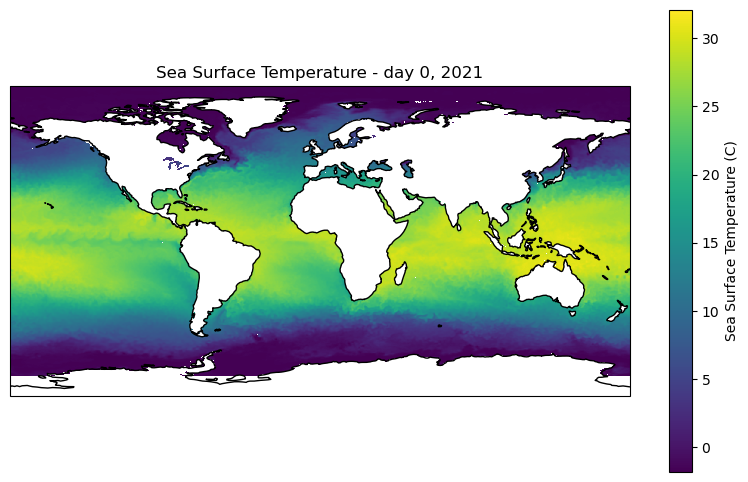

In [35]:
# Create a map projection (choose one appropriate for your region)
projection = ccrs.PlateCarree()  # Example: PlateCarree for global

# Create the figure and axes
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=projection)

# Plot the salinity data
day = 0  # Change this to plot a different day
temp_plot = ax.pcolormesh(temp_lon, temp_lat, temp[day, :, :], cmap='viridis', transform=ccrs.PlateCarree())  # You can change the colormap

# Add coastlines and a colorbar
ax.coastlines()
plt.colorbar(temp_plot, label='Sea Surface Temperature (C)')

# Set title
plt.title('Sea Surface Temperature - day {}, 2021'.format(day))

# Show the plot
plt.show()

# Catch fish data